### Imports

In [174]:
import cv2
import ast
import time

import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sympy import Interval, Union
from tqdm import tqdm, trange
import seaborn as sns
from scipy import ndimage

from PIL import ImageFont, ImageDraw, Image

from helpers.limbus_detection import detect_circle
from helpers.orientation_detection_hybrid import detect_orientation, establish_baseline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### helper functions

In [2]:
def extract_annotations(csv_path, total_frames, label_name, fps=30):
    data = pd.read_csv(csv_path)
    data['points'] = data['points'].apply(lambda x: np.array(ast.literal_eval(x)))
    data['frames'] = data['frames'].apply(lambda x: np.array(ast.literal_eval(x)))
    
    annotations = []
    frames = []
    full_frame_intervals = []
    for _, row in data[data.label_name == label_name].iterrows():
        annotations.append(row['points'])
        frames.append(row['frames'])
        full_frame_intervals.append(Interval(row['frames'][0], row['frames'][-1]))
        
    full_frame_union = Union(*full_frame_intervals)
        
    annotations = np.concatenate(annotations)
    frames = np.concatenate(frames)
    
    sort_index = np.argsort(frames)
    
    annotations = annotations[sort_index]
    frames = frames[sort_index]
    
    annotations_per_frame = []
    cur_index = 0
    for frame in trange(total_frames):
        if cur_index < (len(annotations) - 1) and (frame/30) >= frames[cur_index + 1]:
            cur_index += 1
        
        if full_frame_union.contains(frame/30):
            annotations_per_frame.append(annotations[cur_index])
        else:
            annotations_per_frame.append(None)
        
    return annotations_per_frame
    

In [106]:
def get_orientation(circle, zero_point):
    if circle is None or zero_point is None:
        return None
    
    a = np.array(zero_point)
    b = np.array([circle[0], circle[1]])
    c = a - b
    
    alpha = np.arctan2(c[1], c[0])
    
    if alpha < 0:
        alpha = alpha + 2*np.pi
    
    alpha = 2*np.pi - alpha
    
    return alpha

In [4]:
def get_line_points(circle, zero_point):
    a = np.array(zero_point)
    b = np.array([circle[0], circle[1]])
    c = a - b
    c = c / np.linalg.norm(c)
    c = c * circle[2]
    
    start = b
    end = b + c 
    
    return [round(start[0]), round(start[1])], [round(end[0]), round(end[1])]

In [5]:
def draw_circle(img, circle, color=(0,255,0)):
    center = (round(circle[0]),round(circle[1]))
    radius = round(circle[2])
    cv2.circle(img, center, radius, color)

In [6]:
def draw_axis(img, circle, zero_point, color=(0,255,0)):
    start, end = get_line_points(circle, zero_point)
    cv2.line(img, start, end, color)

In [155]:
def draw_axis_orientation(img, circle, orientation, color=(0,255,0)):
    rad = np.pi * orientation / 180.0
    zero_point = circle[:2] + np.array([
        np.cos(rad),
        -np.sin(rad)
    ])
    start, end = get_line_points(circle, zero_point)
    cv2.line(img, start, end, color)

In [7]:
def numpy_array_robust(l):
    size = None
    for el in l:
        if el is not None:
            size = len(el)
            break
            
    return np.array([
        (
            el
            if el is not None 
            else np.array(size*[np.nan])
        )
        for el in l
    ])

#### displaying the ground truth

In [20]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')
annotation_path = 'data/annotations/6238-first-4.csv'

print('extracting circles')
ground_truth_circles = extract_annotations(annotation_path, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), 'limbus')
ground_truth_circles = numpy_array_robust(ground_truth_circles)
print('extracting orientation')
ground_truth_zero_points = extract_annotations(annotation_path, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), 'orientation')
ground_truth_zero_points = numpy_array_robust(ground_truth_zero_points)

extracting circles


100%|███████████████████████████████████████| 3873/3873 [00:45<00:00, 84.67it/s]


extracting orientation


100%|██████████████████████████████████████| 3873/3873 [00:17<00:00, 216.64it/s]


In [ ]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')
frame = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break

    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]
    
    # visualization
    vis = cv2.cvtColor(base_value, cv2.COLOR_GRAY2BGR)
    circle = ground_truth_circles[frame]
    zero_point = ground_truth_zero_points[frame]
    if circle is not None:
        draw_circle(vis, circle)
        if zero_point is not None:
            draw_axis(vis, circle, zero_point)
#             print(180*get_orientation(circle, zero_point)/np.pi)
    else:
        cv2.putText(vis, 'no detection', (10,10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255))

    cv2.imshow('result', base)
    cv2.imshow('visualization', vis)
    
    frame += 1

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

#### limbus tracking: naive vs. inout

visualization (optional)

In [ ]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')
frame = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break

    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]
    
    # visualization
    vis = cv2.cvtColor(base_value, cv2.COLOR_GRAY2BGR)
    ground_truth_circle = ground_truth_circles[frame]
    if ground_truth_circle is not None:
        draw_circle(vis, ground_truth_circle)
    else:
        cv2.putText(vis, 'no groundtruth', (10,10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255))
        
    # detection
    circle = detect_circle(
        base_value,
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=0.1,
        circle_width_to_radius_ratio=0.059,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=320,
        gaussian_blur_sigma=2.3
    )
    if circle is not None:
        draw_circle(vis, circle, (255,0,0))

    cv2.imshow('result', base)
    cv2.imshow('visualization', vis)
    
    frame += 1

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

computation

In [13]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')
circles_inout = []
circles_first = []

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total=total_frames)
frame = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
        
    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]
        
    # first
    circle = detect_circle(
        base_value,
        validation='first',
        circle_width_to_radius_ratio=0.059,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=320,
        gaussian_blur_sigma=2.3
    )
    circles_first.append(circle)
    
    # inout
    circle = detect_circle(
        base_value,
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=0.1,
        circle_width_to_radius_ratio=0.059,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=320,
        gaussian_blur_sigma=2.3
    )
    circles_inout.append(circle)
    
    pbar.update()

    if cv2.waitKey(25) == ord('q'):
        break
        
pbar.close()

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

100%|██████████████████████████████████████▉| 3872/3873 [02:45<00:00, 23.34it/s]


In [107]:
ground_truth_circles = ground_truth_circles[:len(circles_first)]
ground_truth_zero_points = ground_truth_zero_points[:len(circles_first)]
ground_truth_orientations = [
    get_orientation(ground_truth_circles[i], ground_truth_zero_points[i])
    for i in range(len(circles_first))
]

In [15]:
circles_first = numpy_array_robust(circles_first)
circles_inout = numpy_array_robust(circles_inout)

centration & radius diffrence

In [96]:
centration_first = np.linalg.norm(circles_first[:,:2] - ground_truth_circles[:,:2], axis=1)
# TODO: normalization by radius might be better
centration_first_normalized = centration_first / (2*ground_truth_circles[:,2])

centration_inout = np.linalg.norm(circles_inout[:,:2] - ground_truth_circles[:,:2], axis=1)
# TODO: normalization by radius might be better
centration_inout_normalized = centration_inout / (2*ground_truth_circles[:,2])

radius_diff_first = np.abs(circles_first[:,2] - ground_truth_circles[:,2])
radius_diff_first_normalized = radius_diff_first / ground_truth_circles[:,2]
radius_diff_inout = np.abs(circles_inout[:,2] - ground_truth_circles[:,2])
radius_diff_inout_normalized = radius_diff_inout / ground_truth_circles[:,2]

In [98]:
df = pd.DataFrame({
    'method': len(centration_first)*['first'] + len(centration_inout)*['inout'],
    'centration': centration_first.tolist() + centration_inout.tolist(),
    'ground_truth_radius': ground_truth_circles[:,2].tolist()*2,
    'centration_normalized': centration_first_normalized.tolist() + centration_inout_normalized.tolist(),
    'radius_diff': radius_diff_first.tolist() + radius_diff_inout.tolist(),
    'radius_diff_normalized': radius_diff_first_normalized.tolist() + radius_diff_inout_normalized.tolist(),
})

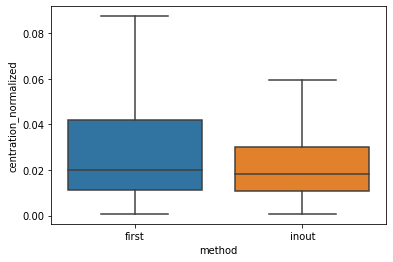

In [191]:
ax = sns.boxplot(x='method', y='centration_normalized', showfliers=False, data=df)
plt.savefig('a.pdf')

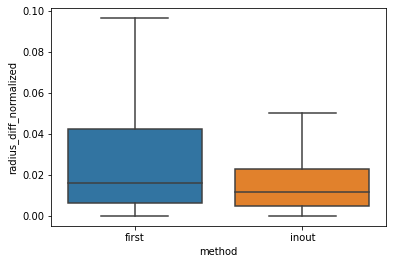

In [192]:
ax = sns.boxplot(x='method', y='radius_diff_normalized', showfliers=False, data=df)
plt.savefig('b.pdf')

#### orientation tracking

visualization (optional)

In [164]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame = 0
baseline = None
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
        
    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]
    vis = cv2.cvtColor(base_value, cv2.COLOR_GRAY2BGR)
    
    # inout
    circle = detect_circle(
        base_value,
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=0.1,
        circle_width_to_radius_ratio=0.059,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=320,
        gaussian_blur_sigma=2.3
    )
    
    orientation = None
    if circle is not None:
        draw_circle(vis, circle, (255,0,0))
        if frame == 0:
            baseline = establish_baseline(base_value, circle)
            orientation = 0.0
        else:
            orientation = detect_orientation(base_value, circle, baseline)
        
        if orientation is not None:
            orientation = 180.0 * orientation / np.pi
            cv2.putText(vis, str(round(orientation)), (20,20), cv2.FONT_HERSHEY_COMPLEX, 1, (255,0,0))
            draw_axis_orientation(vis, circle, orientation, (255,0,0))
    
    cv2.imshow('visualization', vis)
    frame += 1

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

computation

In [201]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')
orientations = []

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pbar.close()
pbar = tqdm(total=total_frames)
frame = 0
baseline = None
baseline_reset_frames = 500
baseline_is_reseting = False
baseline_orientation = 0.0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
        
    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]
    
    # inout
    circle = detect_circle(
        base_value,
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=0.1,
        circle_width_to_radius_ratio=0.059,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=320,
        gaussian_blur_sigma=2.3
    )
    
    if frame != 0 and (frame % baseline_reset_frames) == 0:
        baseline_is_reseting = True
    
    orientation = None
    if circle is not None:
        if frame == 0:
            baseline = establish_baseline(base_value, circle)
            orientation = 0.0
            print(f'{frame}; baseline established')
        else:
            orientation = detect_orientation(base_value, circle, baseline)
            if orientation is not None:
                orientation = (orientation + baseline_orientation) % (2*np.pi)
                if baseline_is_reseting:
                    print(f'{frame}; baseline established')
                    baseline = establish_baseline(base_value, circle)
                    baseline_orientation = orientation
                    baseline_is_reseting = False
    
    orientations.append(orientation)
    
    pbar.update()
    frame += 1

    if cv2.waitKey(25) == ord('q'):
        break
        
pbar.close()

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

  0%|                                          | 4/3873 [00:00<03:51, 16.70it/s]

0; baseline established


 13%|█████▏                                  | 504/3873 [00:29<03:22, 16.64it/s]

500; baseline established


 26%|██████████                             | 1004/3873 [00:58<02:58, 16.08it/s]

1000; baseline established


 39%|███████████████▏                       | 1504/3873 [01:28<02:27, 16.03it/s]

1500; baseline established


 52%|████████████████████▏                  | 2004/3873 [01:56<01:46, 17.59it/s]

2000; baseline established


 65%|█████████████████████████▏             | 2504/3873 [02:23<01:17, 17.73it/s]

2500; baseline established


 78%|██████████████████████████████▏        | 3003/3873 [02:50<00:49, 17.58it/s]

3000; baseline established


 90%|███████████████████████████████████▎   | 3502/3873 [03:18<00:23, 15.57it/s]

3500; baseline established


100%|██████████████████████████████████████▉| 3872/3873 [03:41<00:00, 17.46it/s]


In [202]:
orientations_processed = np.array([(o if o is not None else np.nan) for o in orientations])
orientations_processed = orientations_processed - orientations_processed[0] + ground_truth_orientations[0]
orientations_processed = orientations_processed + 4*np.pi
orientations_processed = orientations_processed % (2*np.pi)
orientations_processed_deg = 180.0 * orientations_processed / np.pi

/var/folders/qt/v86lr1d51fj_scwcvj3n1v8h0000gn/T/ipykernel_7652/2435041019.py:4: RuntimeWarning: invalid value encountered in remainder
  orientations_processed = orientations_processed % (2*np.pi)


In [203]:
ground_truth_orientations_deg = 180.0 * np.array(ground_truth_orientations) / np.pi
ground_truth_orientations_deg = ground_truth_orientations_deg[:len(orientations_processed_deg)]

In [204]:
orientation_diff = orientations_processed_deg - ground_truth_orientations_deg
orientation_diff = (orientation_diff + 180) % 360 - 180
orientation_diff = np.abs(orientation_diff)

/var/folders/qt/v86lr1d51fj_scwcvj3n1v8h0000gn/T/ipykernel_7652/1726909904.py:2: RuntimeWarning: invalid value encountered in remainder
  orientation_diff = (orientation_diff + 180) % 360 - 180


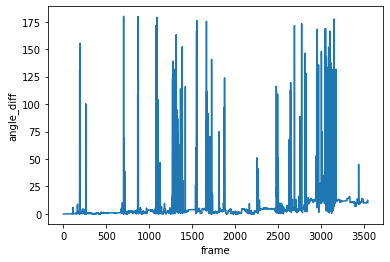

In [205]:
N = 1
test = orientation_diff[~np.isnan(orientation_diff)]
plt.plot(np.convolve(test, np.ones(N)/N, mode='valid'))
plt.xlabel('frame')
plt.ylabel('angle_diff')
plt.savefig('c.pdf')

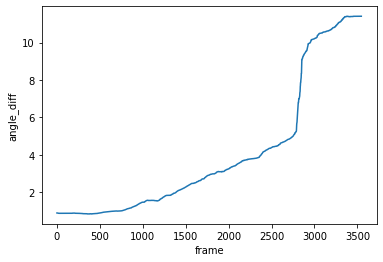

In [206]:
plt.plot(ndimage.median_filter(test, size=30*60))
plt.xlabel('frame')
plt.ylabel('angle_diff')
plt.savefig('d.pdf')